In [1146]:
import autograd.numpy as np 
from autograd import grad, elementwise_grad, jacobian, make_jvp , holomorphic_grad
from autograd.extend import primitive, defvjp, defjvp
from autograd.scipy.special import erf

import GPy
from GPy.kern import Kern
from GPy.core.parameterization.param import Param

import matplotlib.pyplot as plt
import scipy
from scipy.special import wofz

## Adding Fadeeva to Autograd

In [1979]:
inv_root_pi = 0.56418958354775627928

# defvjp(wofz, lambda ans, x: lambda g:  g * ( -2j * x * wofz(x) - 2.0 * inv_root_pi ) )
# −2zw(z)+(2i/π−−√),
 
wofz =  primitive(scipy.special.wofz)
defvjp(wofz, lambda ans, x: lambda g:  g * ( -2 * x * wofz(x) + 2.0j * inv_root_pi ) )

### Manual Gradient Check

In [1437]:
from autograd import grad, elementwise_grad, jacobian, make_jvp , holomorphic_grad


jacobian(lambda x, y: np.real(x* wofz(y)) ,1)(np.ones((3,3) ), np.array(1) ).shape

(3, 3)

In [1428]:
# from autograd.wrap_util import unary_to_nary
# from autograd.builtins import tuple as atuple
# from autograd.core import make_vjp as _make_vjp, make_jvp as _make_jvp
# from autograd.extend import primitive, defvjp_argnum, vspace

# make_vjp = unary_to_nary(_make_vjp)
# make_jvp = unary_to_nary(_make_jvp)
# @unary_to_nary
# def jacobian(fun, x):
#     """
#     Returns a function which computes the Jacobian of `fun` with respect to
#     positional argument number `argnum`, which must be a scalar or array. Unlike
#     `grad` it is not restricted to scalar-output functions, but also it cannot
#     take derivatives with respect to some argument types (like lists or dicts).
#     If the input to `fun` has shape (in1, in2, ...) and the output has shape
#     (out1, out2, ...) then the Jacobian has shape (out1, out2, ..., in1, in2, ...).
#     """
#     print("entered jac")
#     vjp, ans = _make_vjp(fun, x)
#     print("done with jp")
#     ans_vspace = vspace(ans)
#     jacobian_shape = ans_vspace.shape + vspace(x).shape
#     print("bottle")
#     grads = map(vjp, ans_vspace.standard_basis())
#     print("kneck")
#     print("real bottle", jacobian_shape, ans_vspace.shape, vspace(x).shape)
#     out = np.reshape(np.stack(grads), jacobian_shape)
#     print("kneck")
#     print(out.shape)
#     return out


# @unary_to_nary
# def jacobian(fun, x):
#     """
#     Returns a function which computes the Jacobian of `fun` with respect to
#     positional argument number `argnum`, which must be a scalar or array. Unlike
#     `grad` it is not restricted to scalar-output functions, but also it cannot
#     take derivatives with respect to some argument types (like lists or dicts).
#     If the input to `fun` has shape (in1, in2, ...) and the output has shape
#     (out1, out2, ...) then the Jacobian has shape (out1, out2, ..., in1, in2, ...).
#     """
#     print(fun.__name__)
#     vjp, ans = _make_vjp(fun, x)
    
#     ans_vspace = vspace(ans)
#     vspace_x = vspace(x).shape
    
#     jacobian_shape = ans_vspace.shape + vspace_x
    
#     if fun.__name__ ==  "wofz":
#         _, ans_aux = _make_vjp(lambda x: np.real(fun(x)), x)
#         ans_vspace = vspace(ans_aux)
#         jacobian_shape = ans_vspace.shape
    
#     print(list(ans_vspace.standard_basis()))
#     grads = map(vjp, ans_vspace.standard_basis())

#     f =np.stack(grads)
#     if fun.__name__ ==  "wofz":
#         f = f.sum(axis=0)
#         print(f)
#     print(f.shape)
# #     print(list(ans_vspace.standard_basis()))
# #     print(ans, vspace(x).shape, ans_vspace.shape + vspace(x).shape)
# #     print(fun(x))
# #     print(f, f.shape, jacobian_shape)
#     return np.reshape(f, jacobian_shape)


# gg = jacobian(wofz)

In [1426]:
# gg = jacobian(wofz)

# gg(np.array([[1+8.0j, 1], [1,2], [3,4]])).shape
# # array([[-2.56609742e-27-0.00903062j]])
# # array([[-0.00903062+2.56609742e-27j]])


In [1366]:
x = 1+ 8.0j
-2 * x * wofz(x) + 2.0j * inv_root_pi 

(-0.0020459055037121976+0.008242177574274479j)

In [1367]:
x = 1
-2 * x * wofz(x) + 2.0j * inv_root_pi 

(-0.7357588823428847-0.08593624458727489j)

In [1390]:
epsilon = 1e-10
(wofz(1j*8 + 1j * epsilon) - wofz(1j*8) ) / epsilon

(-0.008616579671993918+0j)

In [1391]:
x = 8j
-2 * x * wofz(x) + 2.0j * inv_root_pi 

0.008616507881417546j

## Implementing h and auxiliary function (loopy implementation)

In [1941]:
# wofz = primitive(lambda x: (scipy.special.wofz(x)))

def digamma_like_q(t1, t2, γd, lq):
    
    zdt1 = (t1 - t2) / lq - 0.5 * lq * γd
    zd0 = (-t2 ) / lq - 0.5 * lq * γd
    
    term1 = 2 * np.exp( 0.25 * (lq * γd)**2 - (t1 -t2) * γd )
    term2 = np.exp(-(t1-t2)**2 / lq**2)  * wofz(1.0j * zdt1)
    term3 = np.exp(-(t2)**2 / lq**2) * np.exp(-t1 * γd) * wofz(-1.0j * zd0)
    
    return term1 - term2 - term3


def h_q(t1, t2, γd1, γd2, lq):
    num = digamma_like_q(t2, t1, γd1, lq) - np.exp(-γd2 * t1) * digamma_like_q(t2, 0, γd1, lq) 
#     import pdb; pdb.set_trace()
    denom = γd1 + γd2
    return num / denom


def k_q(t1, t2, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 , h_q=h_q):
    α_d1 = 0.5 * Cd1
    ω_d1 = 0.5 * np.sqrt(4 * Bd1 - Cd1**2)
    
    α_d2 = 0.5 * Cd2
    ω_d2 = 0.5 * np.sqrt(4 * Bd2 - Cd2**2)
    
    γd1 = α_d1 + 1.0j * ω_d1
    tγd1 = α_d1 - 1.0j * ω_d1
    
    γd2 = α_d2 + 1.0j * ω_d2
    tγd2 = α_d2 - 1.0j * ω_d2
    
    K_qd = lq  * np.sqrt(np.pi) / (8.0 * ω_d2 * ω_d1)
    
    
    
    h_tγd2_γd1_t1_t2 = h_q(t1, t2, tγd2, γd1, lq)
    
    h_γd1_tγd2_t2_t1 = h_q(t2, t1, γd1, tγd2, lq)
    h_γd2_tγd1_t1_t2 = h_q(t1, t2, γd2, tγd1, lq)
    h_tγd1_γd2_t2_t1 = h_q(t2, t1, tγd1, γd2, lq)
    
    
#     import pdb; pdb.set_trace()
#     
    h_tγd2_tγd1_t1_t2 = h_q(t1, t2, tγd2, tγd1, lq)
    h_tγd1_tγd2_t2_t1 = h_q(t2, t1, tγd1, tγd2, lq)
    h_γd2_γd1_t1_t2 = h_q(t1, t2, γd2, γd1, lq)
    h_γd1_γd2_t2_t1 = h_q(t2, t1, γd1, γd2, lq)
    
    
    return K_qd * ((h_tγd2_γd1_t1_t2 + h_γd1_tγd2_t2_t1 + h_γd2_tγd1_t1_t2 + h_tγd1_γd2_t2_t1) 
                  -(h_tγd2_tγd1_t1_t2 + h_tγd1_tγd2_t2_t1 + h_γd2_γd1_t1_t2 + h_γd1_γd2_t2_t1)) 


def k_q_test(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 , debug=False):
    n1 = t1vec.shape[0]
    n2 = t2vec.shape[0]
    out = np.zeros((n1, n2), dtype=np.complex)
    for i, t1 in enumerate(t1vec):
        for j, t2 in enumerate(t2vec):
            
            tmp = Sqd1 *Sqd2 * k_q(t1, t2, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 ) 
            out[i,j] = tmp
    if debug:
        plt.imshow(np.real(out))
    return out


def k_q_test_diag(t1vec, lq, Bd1, Cd1, Md1, Sqd1 ):
    n = t1vec.shape[0]
    out = np.zeros(n, dtype=np.complex)
    for i, t1 in enumerate(t1vec):
        tmp = Sqd1**2 * k_q(t1, t1, lq, Bd1, Cd1, Md1, Sqd1,  Bd1, Cd1, Md1, Sqd1)
        out[i] = tmp
    return out

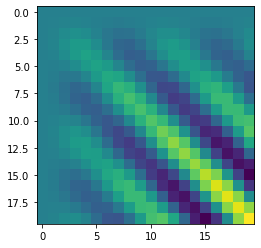

In [2117]:
t1vec = np.linspace(0,20, 20)
l = 1
b = 0.5# 3.5
c = 0.01 #0.5
s = 1
kk = k_q_test(t1vec, t1vec, l, b, c, 1, s, b, c, 1, s )
dkk = k_q_test_diag(t1vec, l, b, c, 1, s)

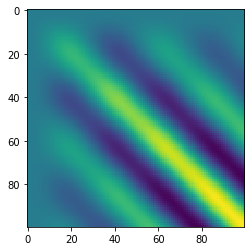

In [1963]:
t1vec = np.linspace(0,20, 100)
l = 1
b = 0.5# 3.5
c = 0.1 #0.5
s = 0.9
kk = k_q_test(t1vec, t1vec, l, b, c, 1, s, b, c, 1, s )
dkk = k_q_test_diag(t1vec, l, b, c, 1, s)

In [1052]:
c /(2 * np.sqrt(b))

0.07905694150420949

In [1053]:
np.abs(np.diag(kk) - dkk)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

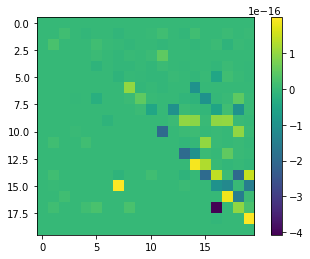

In [2018]:
plt.imshow(np.imag(kk))
plt.colorbar()

In [2019]:
np.abs(np.imag(kk)).max()

4.0687988400317873e-16

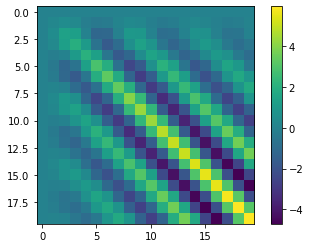

In [2020]:
plt.imshow(np.real(kk), interpolation=None)

plt.colorbar()

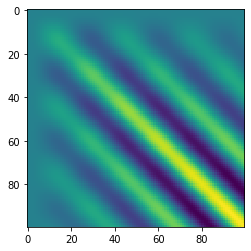

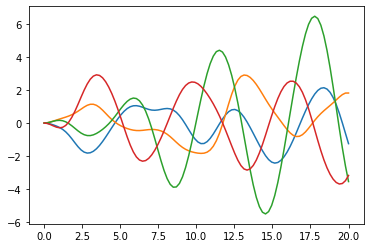

In [2023]:
t1vec = np.linspace(0,20, 100)
l = 1
b = 1# 3.5
c = 0.1 #0.5
s = 1
kk_ = k_q_test(t1vec, t1vec, l, b, c, 1, s, b, c, 1, s )
dkk_ = k_q_test_diag(t1vec, l, b, c, 1, s)
plt.show()

guys = np.random.multivariate_normal(np.zeros(kk_.shape[0]), kk_, 4)
guys.shape
[plt.plot(t1vec, guy) for guy in guys];

In [1947]:
(np.abs(np.real(kk).T - np.real(kk))).max()

8.881784197001252e-16

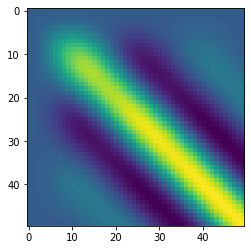

In [1948]:
t1vec = np.linspace(0,11, 50)
fc = 1
fc2 = 1  # 3.5
fc3 = 0.5 # 0.5
fc4 =1
kk = k_q_test(t1vec, t1vec, fc, fc2, fc3, fc4, fc, fc2, fc3, fc4, fc )

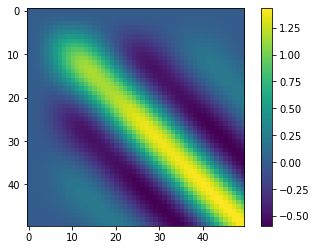

In [1949]:
plt.imshow(np.real(kk), interpolation=None)

plt.colorbar()

# Vectorization attempt

In [2257]:
def vec_digamma_like_q(t1, t2, γd, lq):
    
    t1Minust2 = t1[...,None] - t2
    zdt1 = (t1Minust2) / lq - 0.5 * lq * γd
    zd0 = (-t2[None, ...] ) / lq - 0.5 * lq * γd
    
    term1 = 2 * np.exp( 0.25 * (lq * γd)**2 - (t1Minust2) * γd )
    term2 = np.exp(-(t1Minust2)**2 / lq**2)  * wofz(1.0j * zdt1)
    term3 = np.exp(-(t2[None,...])**2 / lq**2) * np.exp(-t1[..., None] * γd) * wofz(-1.0j * zd0)

    return (term1 - term2 - term3).T


def vec_h_q(t1, t2, γd1, γd2, lq):
    kek = np.exp(-γd2 * t1[...,None]) * vec_digamma_like_q(t2, np.array([0]), γd2, lq) 
    
    num = vec_digamma_like_q(t2, t1, γd1, lq)- np.exp(-γd2 * t1[...,None]) * vec_digamma_like_q(t2, np.array([0]), γd1, lq) 

    denom = γd1 + γd2
    zdt1 = (t1[...,None] - t2) / lq - 0.5 * lq * γd2
    sauce = - np.real(np.exp(-γd2 * t1[...,None]) * vec_digamma_like_q(t2, np.array([0]), γd1, lq) )
    

    return num / denom



def k_q(t1, t2, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 , h_q=h_q):
    α_d1 = 0.5 * Cd1
    ω_d1 = 0.5 * np.sqrt(4 * Bd1 - Cd1**2)
    
    α_d2 = 0.5 * Cd2
    ω_d2 = 0.5 * np.sqrt(4 * Bd2 - Cd2**2)
    
    γd1 = α_d1 + 1.0j * ω_d1
    tγd1 = α_d1 - 1.0j * ω_d1
    
    γd2 = α_d2 + 1.0j * ω_d2
    tγd2 = α_d2 - 1.0j * ω_d2
    
    K_qd = lq  * np.sqrt(np.pi) / (8.0 * ω_d2 * ω_d1)
    
    
    
    h_tγd2_γd1_t1_t2 = h_q(t1, t2, tγd2, γd1, lq)
    h_γd1_tγd2_t2_t1 = h_q(t2, t1, γd1, tγd2, lq).T
    h_γd2_tγd1_t1_t2 = h_q(t1, t2, γd2, tγd1, lq)
    h_tγd1_γd2_t2_t1 = h_q(t2, t1, tγd1, γd2, lq).T
    
    
#     import pdb; pdb.set_trace()
#     
    h_tγd2_tγd1_t1_t2 = h_q(t1, t2, tγd2, tγd1, lq)
    h_tγd1_tγd2_t2_t1 = h_q(t2, t1, tγd1, tγd2, lq).T
    h_γd2_γd1_t1_t2 = h_q(t1, t2, γd2, γd1, lq)
    h_γd1_γd2_t2_t1 = h_q(t2, t1, γd1, γd2, lq).T
    
    
#     plt.imshow(np.real(h_γd1_tγd2_t2_t1))
#     return h_γd1_tγd2_t2_t1
    
    return K_qd * ((h_tγd2_γd1_t1_t2 + h_γd1_tγd2_t2_t1 + h_γd2_tγd1_t1_t2 + h_tγd1_γd2_t2_t1) 
                  -(h_tγd2_tγd1_t1_t2 + h_tγd1_tγd2_t2_t1 + h_γd2_γd1_t1_t2 + h_γd1_γd2_t2_t1)) 


def vec_k_q_test(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1): #, Bd2, Cd2, Md2, Sqd2 ):
    n1 = t1vec.shape[0]
    n2 = t2vec.shape[0]
    out = np.zeros((n1, n2), dtype=np.complex)

    
    tmp = Sqd1 *Sqd1 * k_q(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1, Bd1, Cd1, Md1, Sqd1 , h_q=vec_h_q) 
    out= np.real(tmp)
    return out


def grad_kf(tmat1, tmat2, lvec, bvec, cvec, mvec, Smat, debug=False):
    tmat1 = tmat1.flatten()
    tmat2 = tmat2.flatten()
    
    gradient_funcs = [jacobian(vec_k_q_test, pi) for pi in (2,3,4,5,6)]
    gradients = [gradient(tmat1,tmat2, lvec, bvec, cvec,  mvec , Smat) for gradient in gradient_funcs]
    if debug:
        for grd in gradients:
            plt.imshow(np.squeeze(grd))
            plt.show()
    return gradients


def grad_kf_check(tmat1, tmat2, lvec, bvec, cvec, mvec, Smat, epsilon = 0.00001, debug=False):
    tmat1 = tmat1.flatten()
    tmat2 = tmat2.flatten()
        
    params = (tmat1,tmat2, lvec, bvec, cvec,  mvec , Smat)
    gradients = []
    for pi in (2,3,4,5,6):
        parep = list(params)
        parep[pi] -= epsilon
        grd = (vec_k_q_test(*params) - vec_k_q_test(*parep)) / epsilon
        
#         if pi == 3:
#             import pdb; pdb.set_trace()
        gradients.append(grd)
        if debug:
            plt.imshow(grd)
            plt.show()

    return gradients


def k_q_test_diag(t1vec, lq, Bd1, Cd1, Md1, Sqd1 ):
    return np.diag(vec_k_q_test(t1vec, t1vec, lq, Bd1, Cd1, Md1, Sqd1))
    n = t1vec.shape[0]
    out = np.zeros(n, dtype=np.complex)
    for i, t1 in enumerate(t1vec):
        tmp = Sqd1**2 * k_q(t1, t1, lq, Bd1, Cd1, Md1, Sqd1,  Bd1, Cd1, Md1, Sqd1)
        out[i] = tmp
    return out

In [2315]:
t1vec = np.linspace(0,5, 20) +50
# l = 1
# b = 10# 3.5
# c = 0.3 #0.5
# s = 1


l = 1
b = 10# 3.5
c = 0.001 #0.5
s = 1
kk2 = vec_k_q_test(t1vec, t1vec, l, b, c, 1, s)#, b, c, 1, s )

print(kk2.shape)
print(c /(2 * np.sqrt(b)))
print(np.abs(np.imag(kk2)).max())
print(np.abs(np.real(kk2 - kk2.T)).max())

(20, 20)
0.00015811388300841897
0.0
6.661338147750939e-16


In [2319]:
( l, b, c, 1, s)

(1, 10, 0.001, 1, 1)

0.0

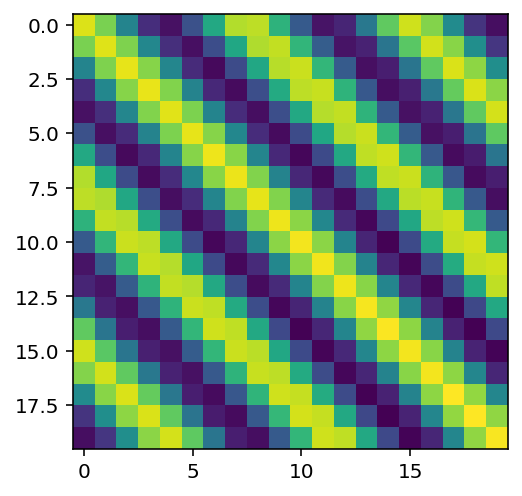

In [2318]:
kk_ = k_q_test(t1vec, t1vec, l, b, c, 1, s, b, c, 1, s )

np.abs(np.real((kk2 - kk_))).sum()

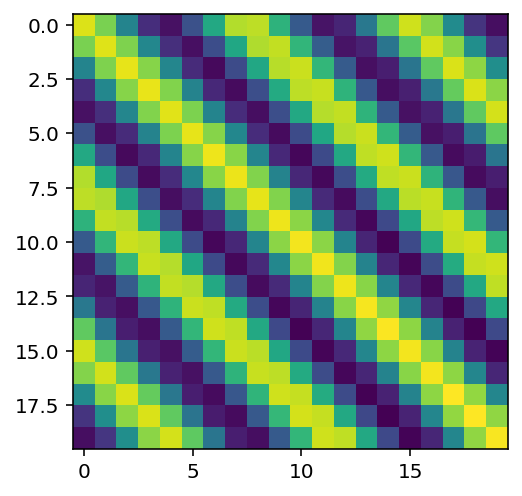

In [2317]:
plt.imshow(kk2)

0.0


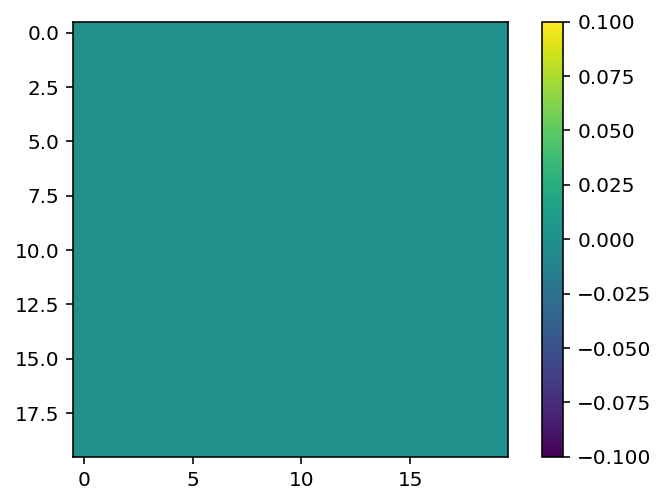

In [2320]:
plt.imshow(np.imag(kk2))
plt.colorbar()
print(np.abs(np.imag(kk2)).max())

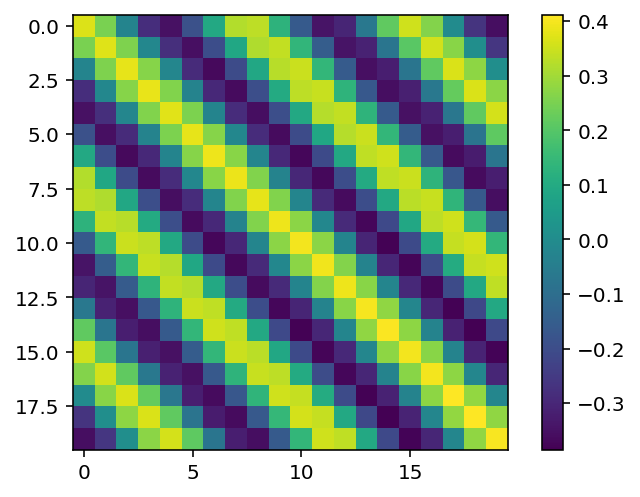

In [2321]:
plt.imshow(np.real(kk2))
plt.colorbar()

In [2322]:
grademp = grad_kf_check(t1vec, t1vec, l, b, c, 1, s,epsilon = 1e-10,  debug=False);

In [2323]:
gradauto = grad_kf(t1vec, t1vec, np.array([l]), np.array([b]), np.array([c]), np.array([1]), np.array([s]), debug=False);

In [2324]:
[np.abs(np.squeeze(gradauto[fg]) - grademp[fg]).max() for fg in range(len(gradauto))]

[0.00021663547895001134,
 0.002560988167586542,
 0.002530622974383334,
 0.0,
 3.3309206426412885e-07]

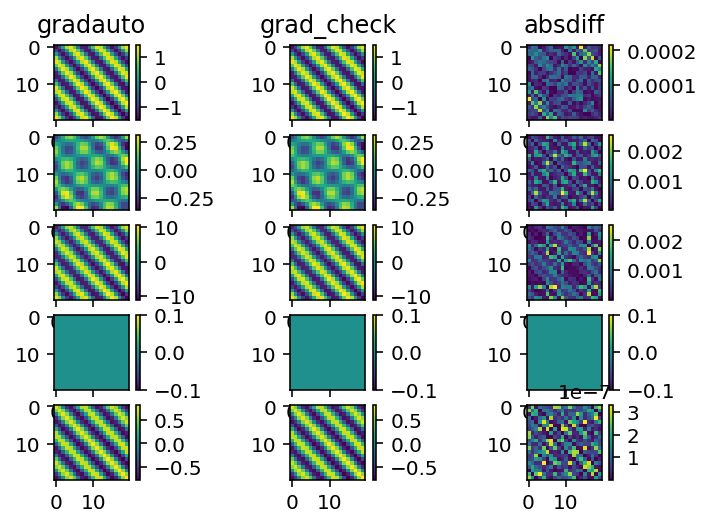

In [2325]:
%matplotlib qt

from mpl_toolkits.axes_grid1 import make_axes_locatable

paramsters =  "l", "b", "c", "m", "s"
fig, axs = plt.subplots(5, 3)



for i in range(len(gradauto)):
    if i == 0:
        axs[i, 0].set_title("gradauto")
        axs[i, 1].set_title("grad_check")
        axs[i, 2].set_title("absdiff")
        
    divider = make_axes_locatable(axs[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = axs[i, 0].imshow(np.squeeze(gradauto[i]))
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(axs[i, 1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = axs[i, 1].imshow(np.squeeze(grademp[i]))
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = axs[i, 2].imshow( np.abs( np.squeeze(grademp[i]) - np.squeeze(gradauto[i]) ) )
    divider = make_axes_locatable(axs[i, 2])
    
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')



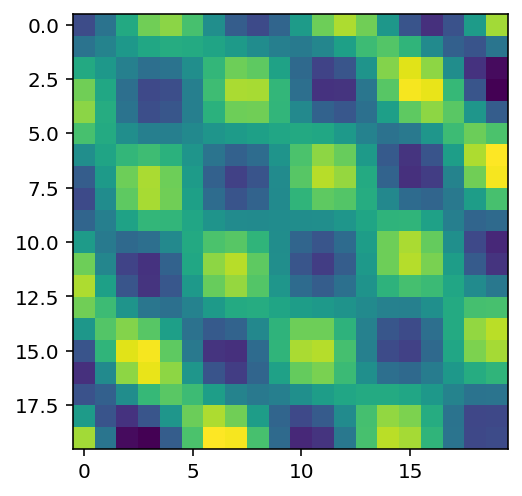

In [2326]:
epsilon = 1e-6
diff = vec_k_q_test(t1vec, t1vec, l, b, c, 1, s) - vec_k_q_test(t1vec, t1vec, l, b-epsilon, c, 1, s)

plt.imshow(np.squeeze(diff/ epsilon))

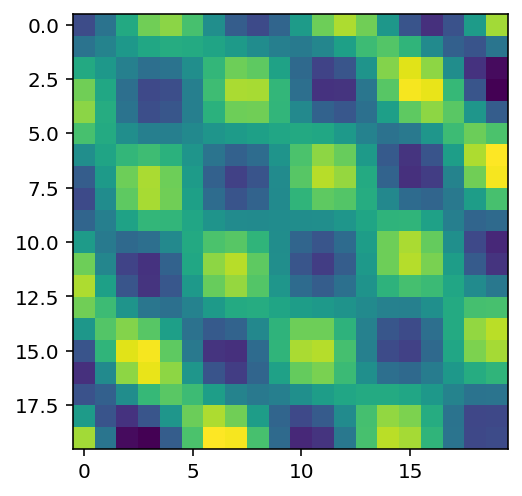

In [2327]:
params = (t1vec, t1vec,l, b, c, 1, s)

parep = list(params)
# print(parep)
parep[3] -= epsilon
# print(parep)
grd = (vec_k_q_test(*params) - vec_k_q_test(*parep)) / epsilon


plt.imshow(grd);

## GPy kernel

In [1384]:
np.abs(np.real(kk - kk.T)).max()


1.0408340855860843e-17

In [1385]:
wofz(1j * np.conj(u))

(0.1484050813195271+0.05593248123328547j)

In [2351]:
class LFM2(GPy.kern.Kern):
    
    def __init__(self,input_dim, bvec=np.array([1.0]),
                 lengthscales=np.array([1.0]),
                 Cvec=np.array([1.0]),
                 Smat=np.array([[1.0]]),
                 active_dims=None, debug=False):
    
        super(LFM2, self).__init__(input_dim, active_dims, 'LFM2')
        
        assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.bvec = Param('bvec', bvec)
        self.lengthscales = Param('lengthscales', lengthscales)
        self.Smat = Param('Smat', Smat)
        self.Cvec = Param('Cvec', Cvec)
        self.link_parameters(self.bvec, self.lengthscales, self.Smat, self.Cvec)
        self.show = False
        self.debug = debug
    
    def K(self,X,X2):
        if X2 is None: X2 = X
            
#         k_q_test(t1vec, t2vec, lq, Bd1, Cd1, Md1, Sqd1, Bd2, Cd2, Md2, Sqd2 )
        Bd1 = Bd2 = self.bvec[0]
        Cd1 = Cd2 = self.Cvec[0]
        Sqd1 = Sqd2 = self.Smat[0,0]
        lq = self.lengthscales[0]
        k = vec_k_q_test(X.flatten(), X2.flatten(), lq, Bd1, Cd1, 1.0, Sqd1) #  Bd2, Cd2, Md2, Sqd2 )


        return np.real(k)
    
    def Kdiag(self, X):
        Bd1 = self.bvec[0]
        Cd1 = self.Cvec[0]
        Sqd1 = self.Smat[0,0]
        lq = self.lengthscales[0]
        return np.diag(self.K(X,X))
    
    def update_gradients_full(self, dL_dK, X, X2):
#         return None
        if X2 is None: X2 = X
#         import pdb; pdb.set_trace
        # (1, 10, 0.001, 1, 1)
#         print(self.lengthscales.values, self.bvec.values, self.Cvec.values, np.array([1.0]), self.Smat.values)
        gradients = grad_kf(X, X2, self.lengthscales.values, self.bvec.values, 
                             self.Cvec.values, np.array([1.0]), self.Smat.values, debug=False)
        
        
        dl = gradients[0]
        db = gradients[1]
        dC = gradients[2]
        dS = gradients[4]
        
        if self.debug:
            fig, axs= plt.subplots(1,4)
            axs[0].imshow(np.squeeze(dl))
            axs[1].imshow(np.squeeze(db))
            axs[2].imshow(np.squeeze(dC))
            axs[3].imshow(np.squeeze(dS))
            plt.show()
        

        self.bvec.gradient = np.sum(db * dL_dK[..., None], axis=(0,1))
        self.lengthscales.gradient =  np.sum(dl * dL_dK[..., None], axis=(0,1))
        self.Cvec.gradient =  np.sum(np.squeeze(dC)[...,None] * dL_dK[..., None], axis=(0,1))
        self.Smat.gradient =  np.sum(dS * dL_dK[..., None, None], axis=(0,1))
        
        

why


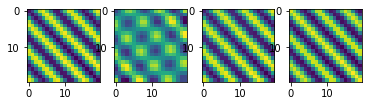

regression


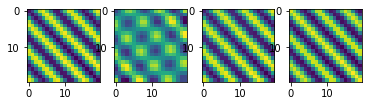

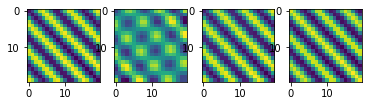

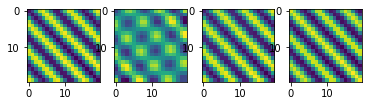

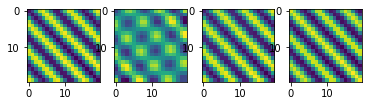

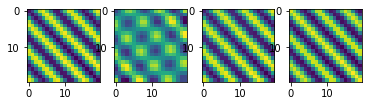

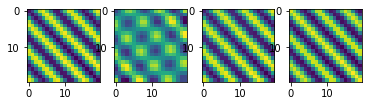

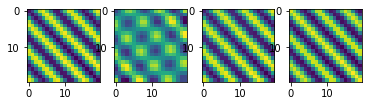

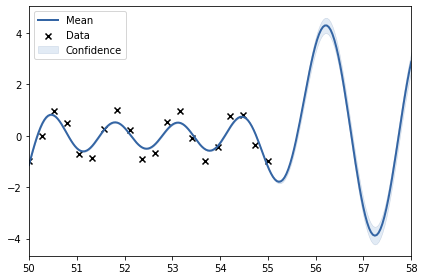

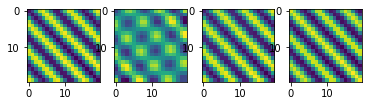

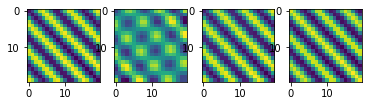

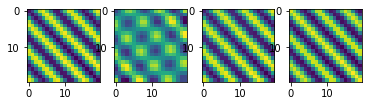

 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:overflow encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:invalid value encountered in multiply
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:overflow encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in multiply
 C:\Users\User\Anacond

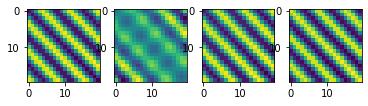

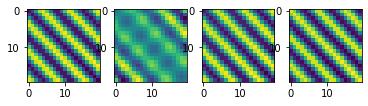

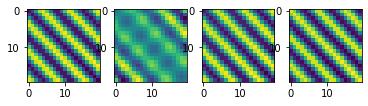

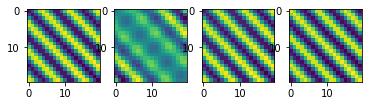

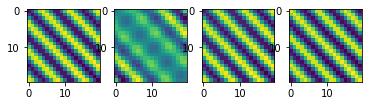

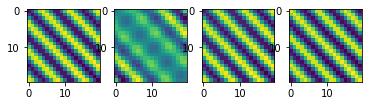

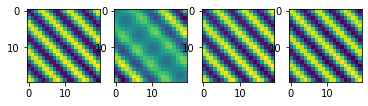

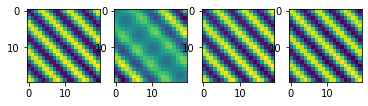

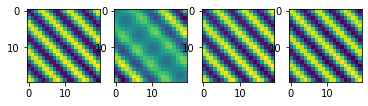

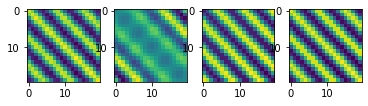

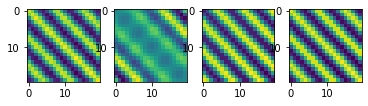

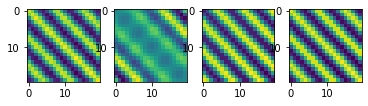

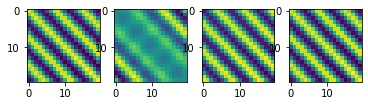

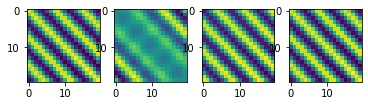

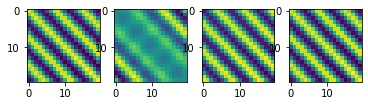

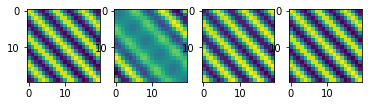

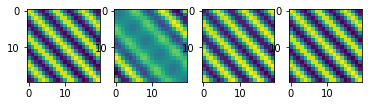

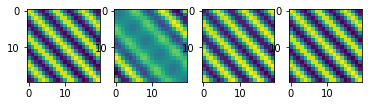

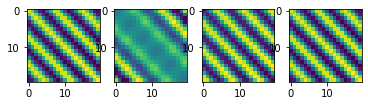

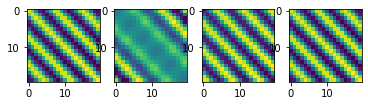

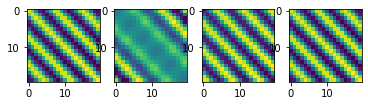

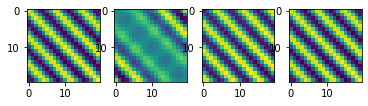

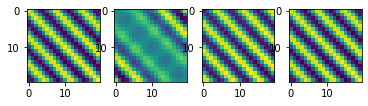

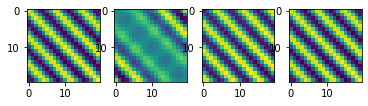

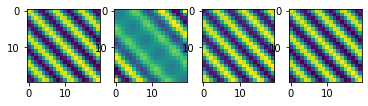

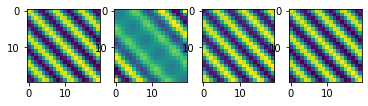

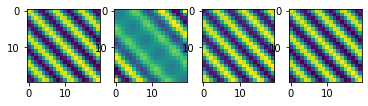

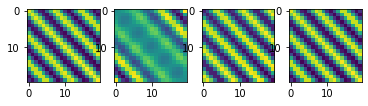

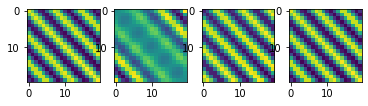

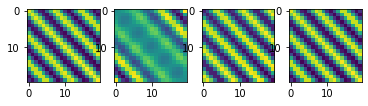

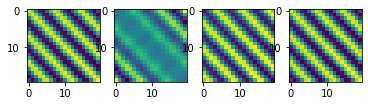

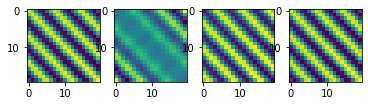

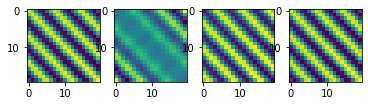

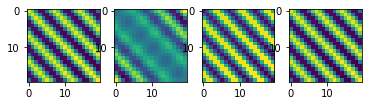

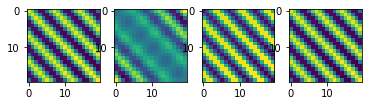

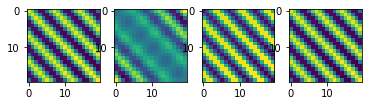

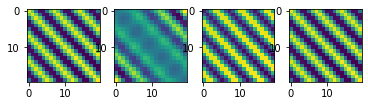

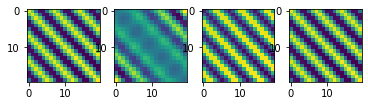

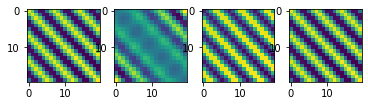

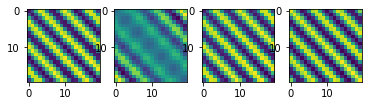

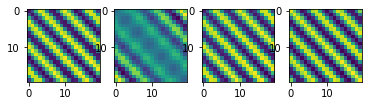

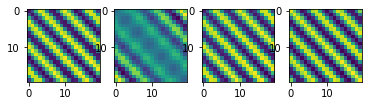

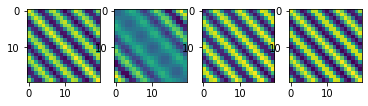

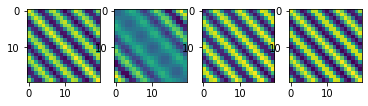

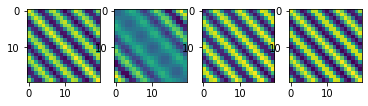

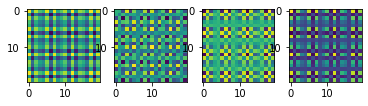

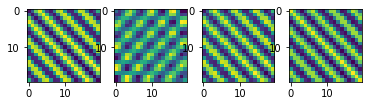

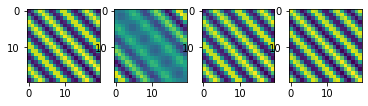

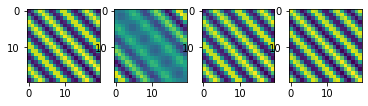

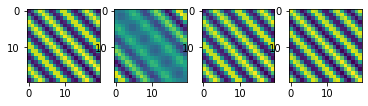

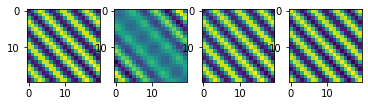

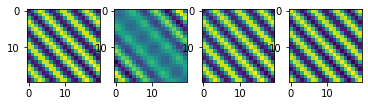

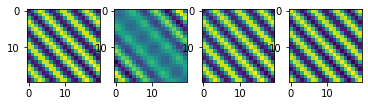

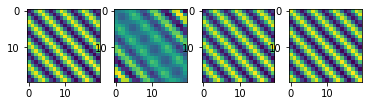

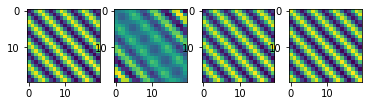

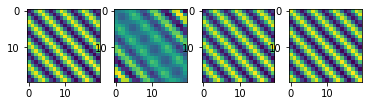

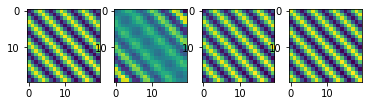

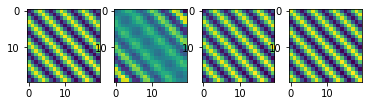

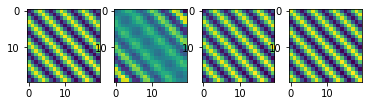

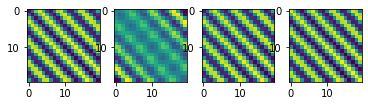

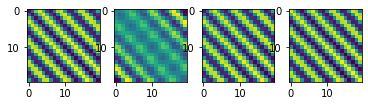

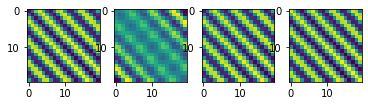

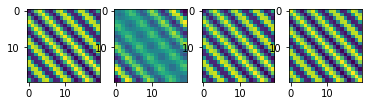

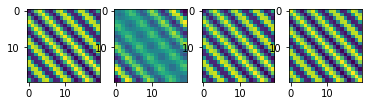

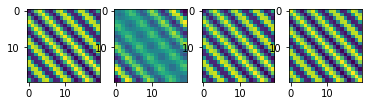

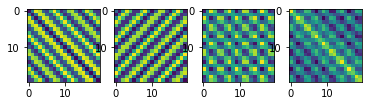

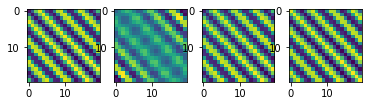

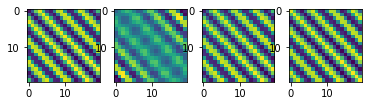

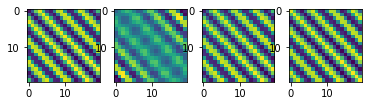

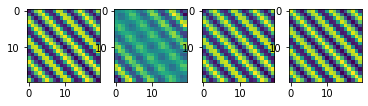

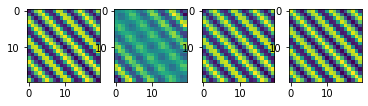

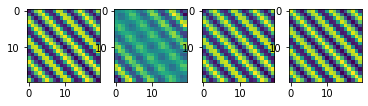

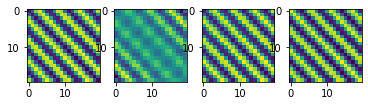

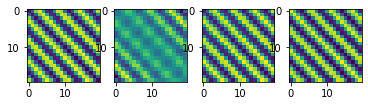

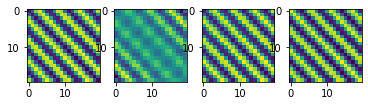

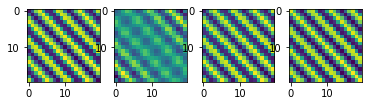

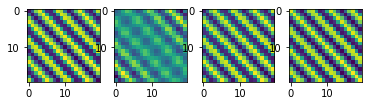

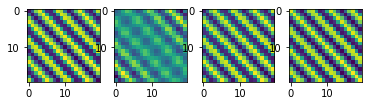

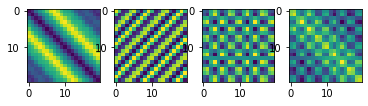

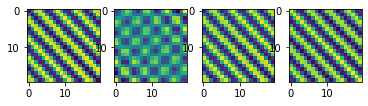

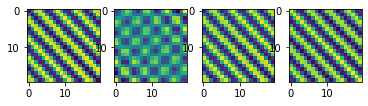

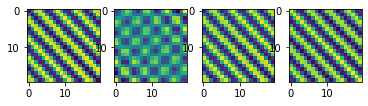

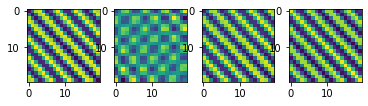

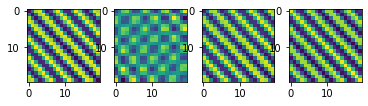

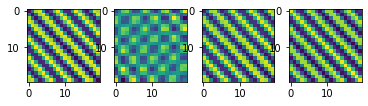

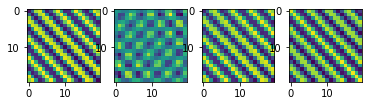

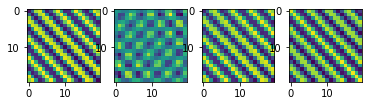

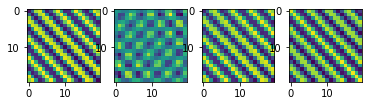

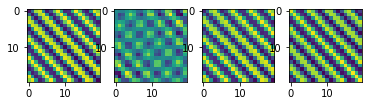

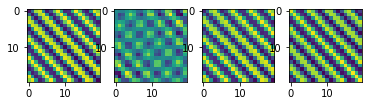

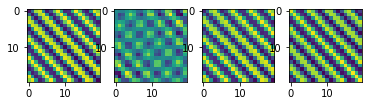

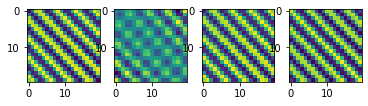

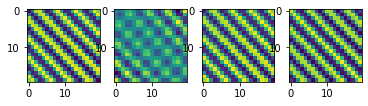

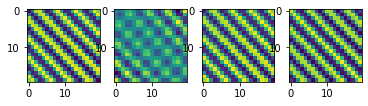

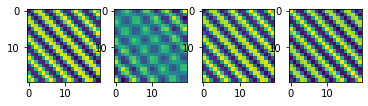

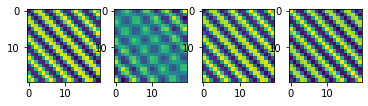

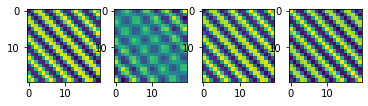

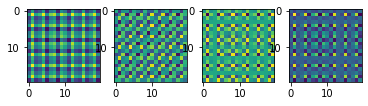

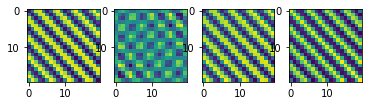

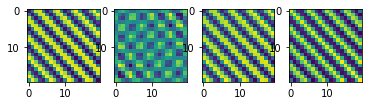

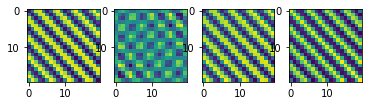

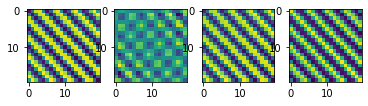

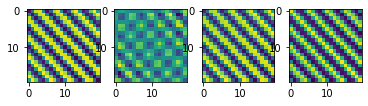

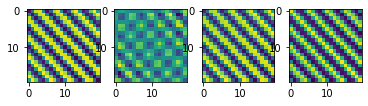

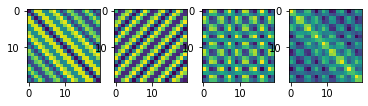

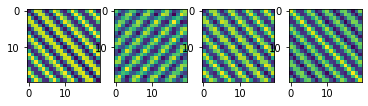

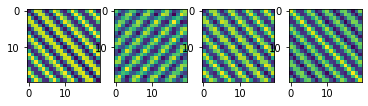

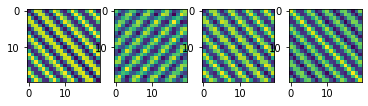

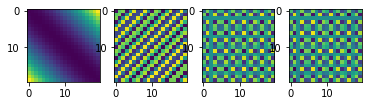

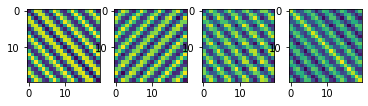

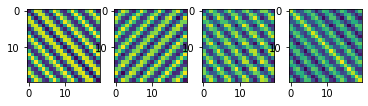

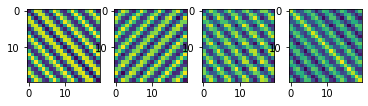

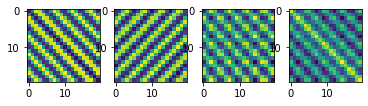

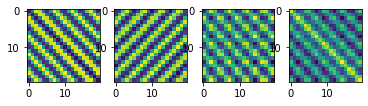

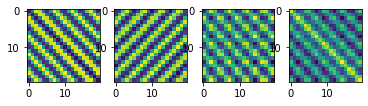

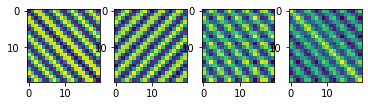

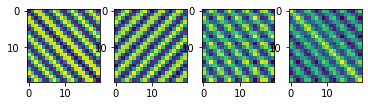

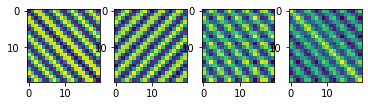

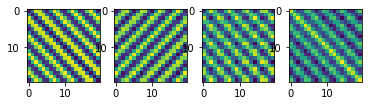

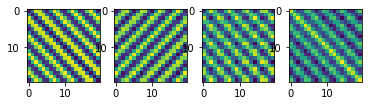

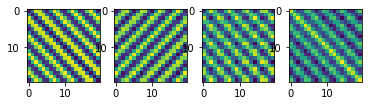

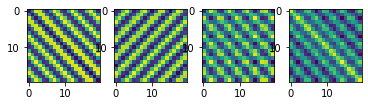

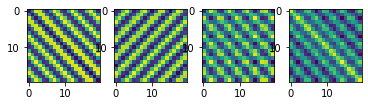

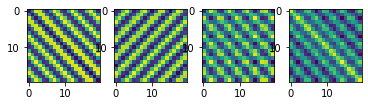

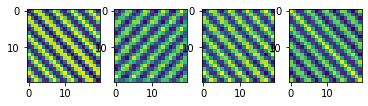

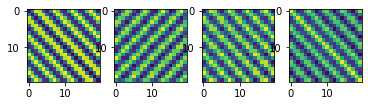

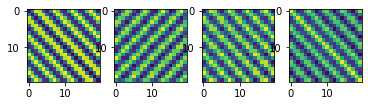

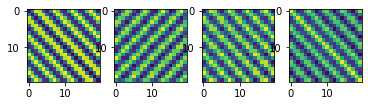

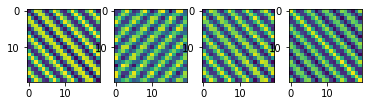

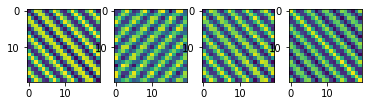

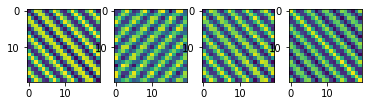

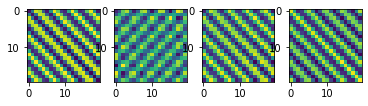

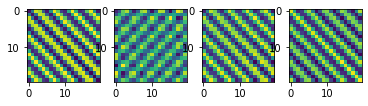

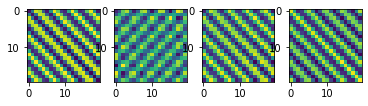

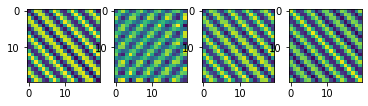

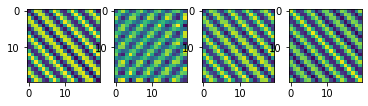

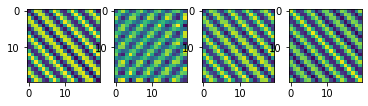

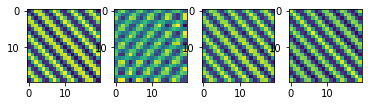

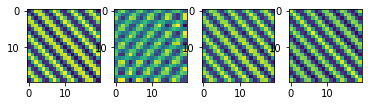

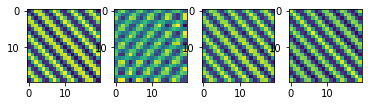

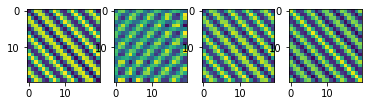

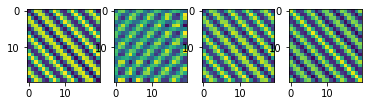

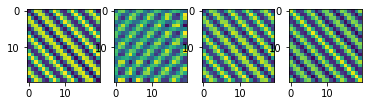

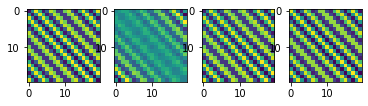

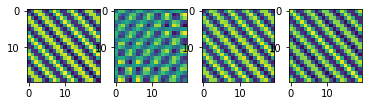

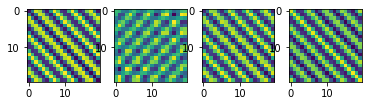

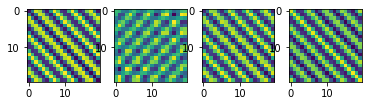

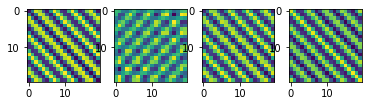

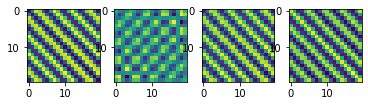

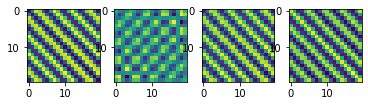

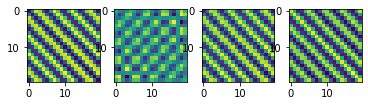

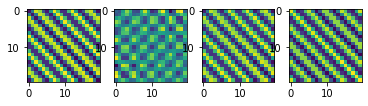

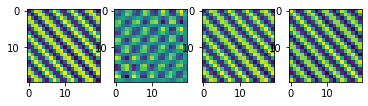

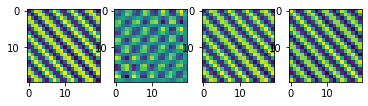

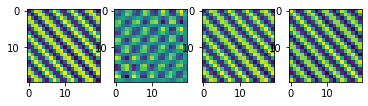

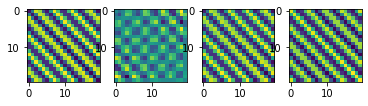

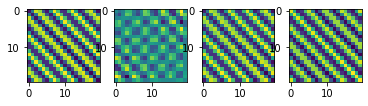

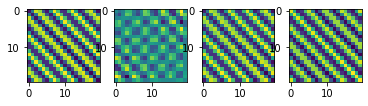

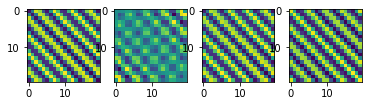

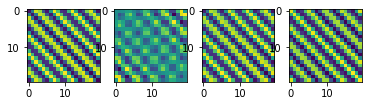

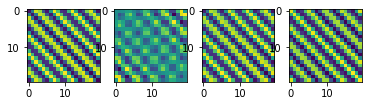

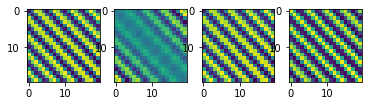

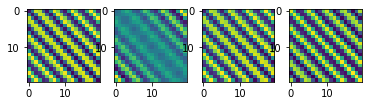

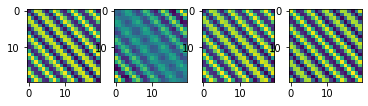

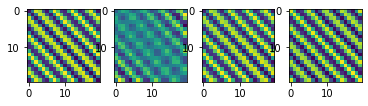

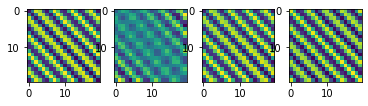

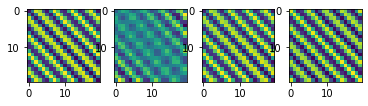

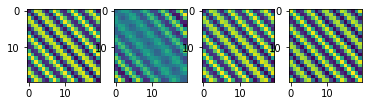

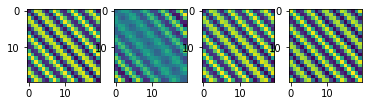

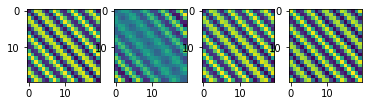

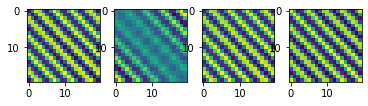

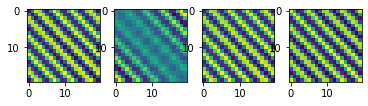

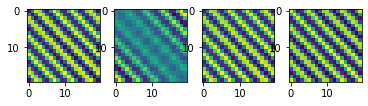

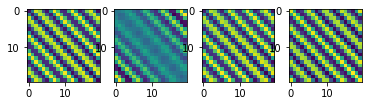

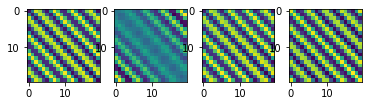

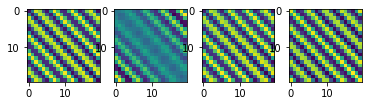

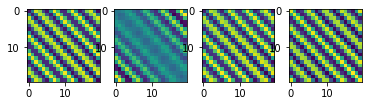

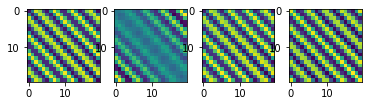

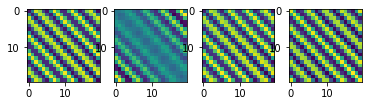

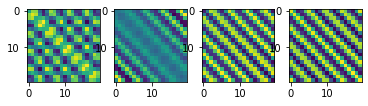

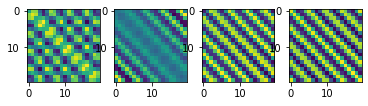

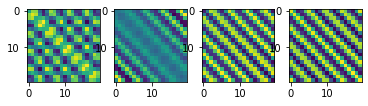

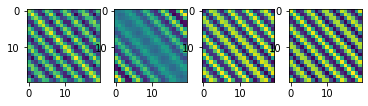

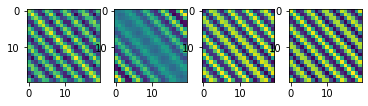

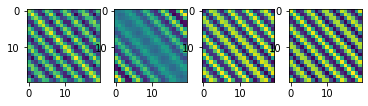

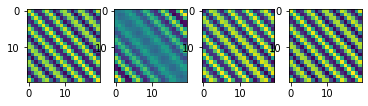

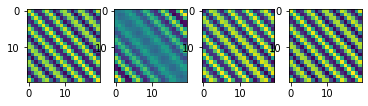

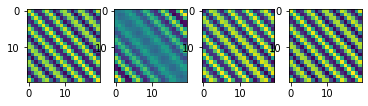

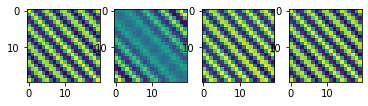

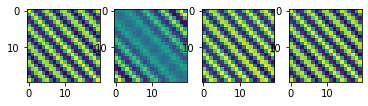

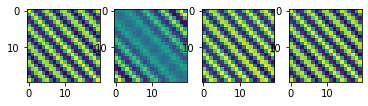

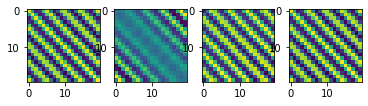

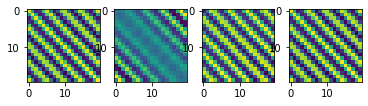

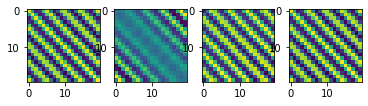

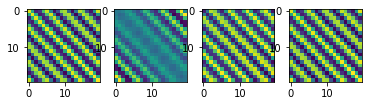

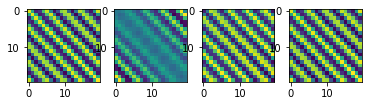

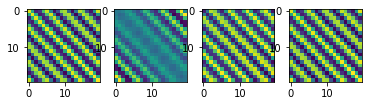

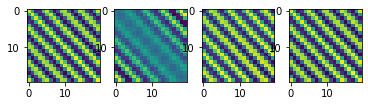

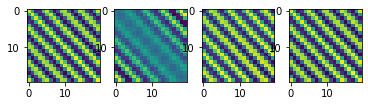

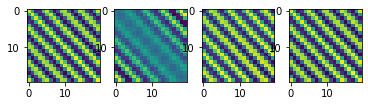

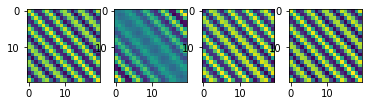

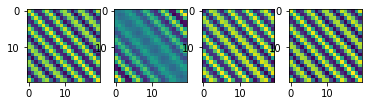

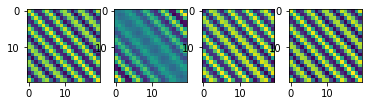

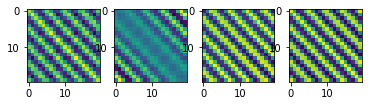

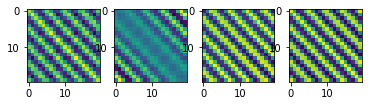

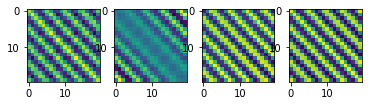

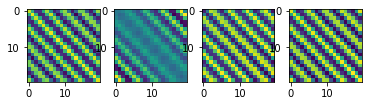

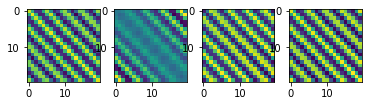

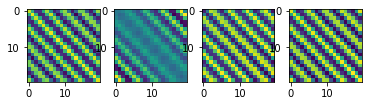

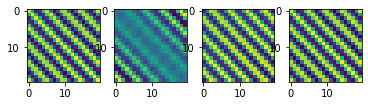

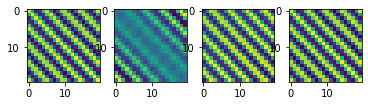

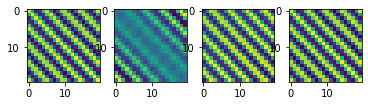

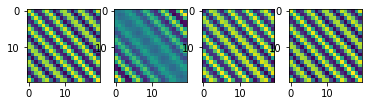

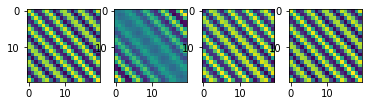

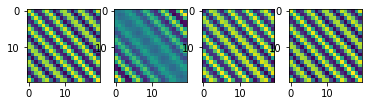

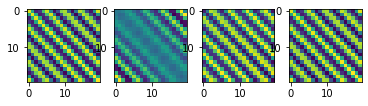

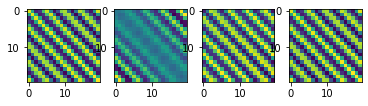

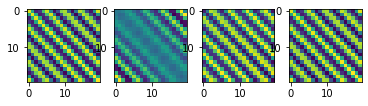

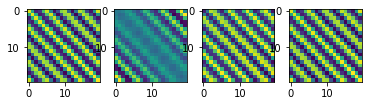

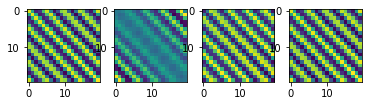

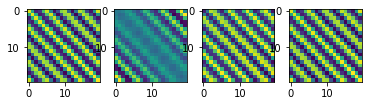

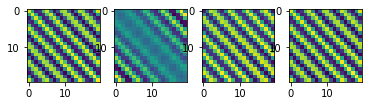

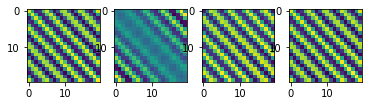

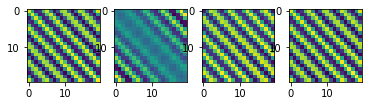

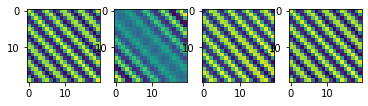

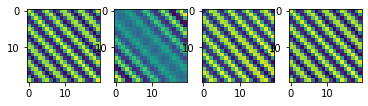

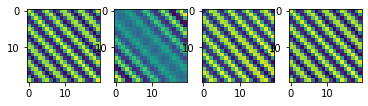

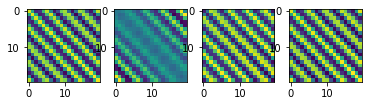

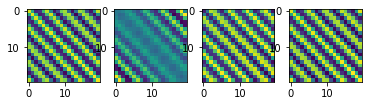

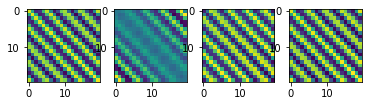

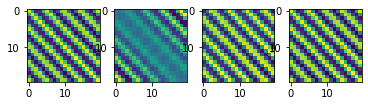

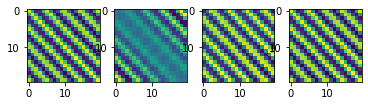

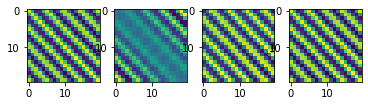

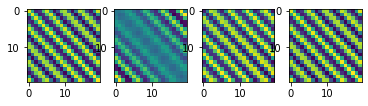

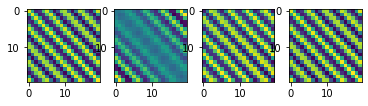

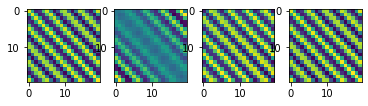

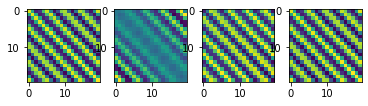

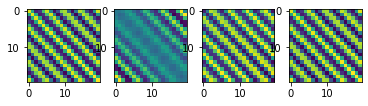

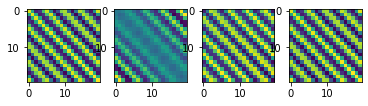

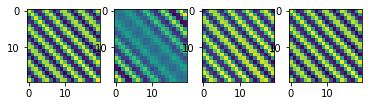

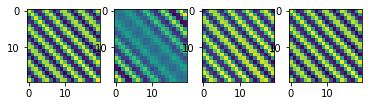

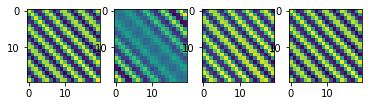

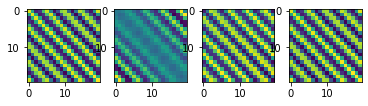

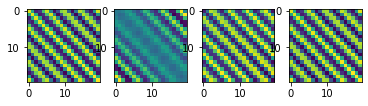

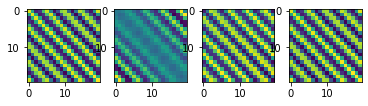

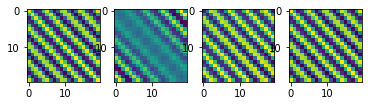

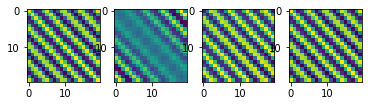

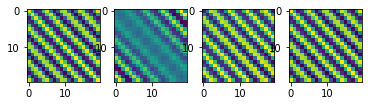

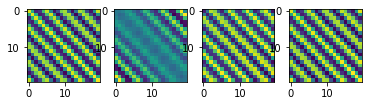

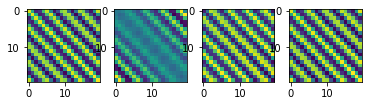

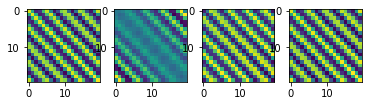

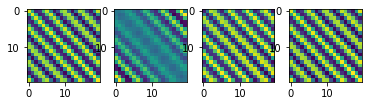

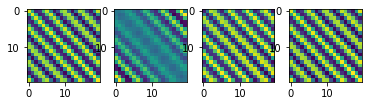

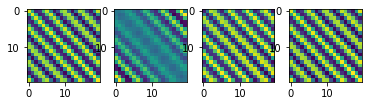

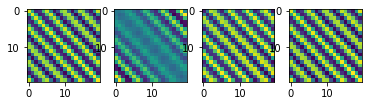

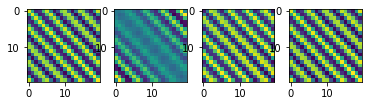

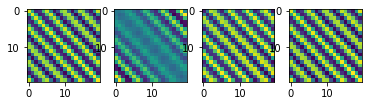

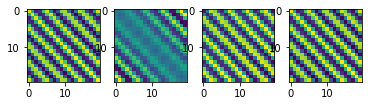

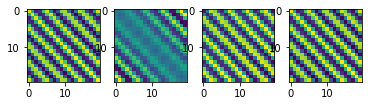

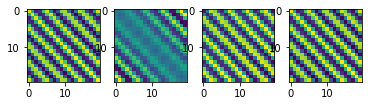

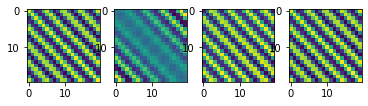

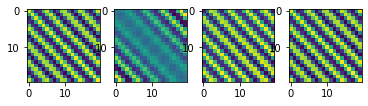

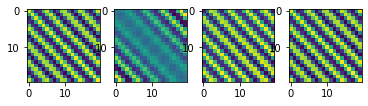

None


 C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning:invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

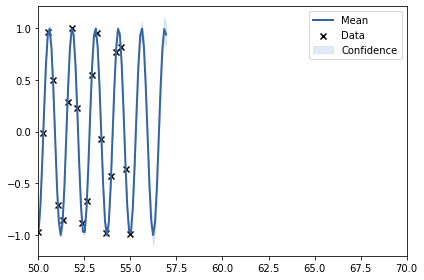

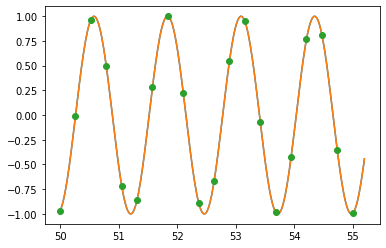

In [2368]:
%matplotlib inline

noise = 1e-4
shift = +50
t1 = np.linspace(0,5, 20).reshape(-1,1) + shift
# create simple GP Model
# kernel_lfm1 = LFM2(input_dim=1,
#                  lengthscales=np.array([1]), bvec=np.array([10]), Cvec=np.array([0.3]),
#                  Smat=np.array([[1.0]]))

kernel_lfm1 = LFM2(input_dim=1,
                 lengthscales=np.array([1]), bvec=np.array([10]), Cvec=np.array([0.001]),
                 Smat=np.array([[1.0]]), debug=True)


y1 = np.sin(5*t1)



# m = GPy.core.gp.GP(t1*3, np.exp(-t1*3), kernel=kernel_lfm1, likelihood=likelihood)
print("why")
m = GPy.models.GPRegression(t1, y1 , kernel=kernel_lfm1, noise_var=noise)
print("regression")

m.kern.lengthscales.constrain_positive() 
m.kern.Cvec.constrain_positive() 
m.kern.Smat.constrain_positive() 
m.likelihood.variance.fix()

m.plot(plot_limits=(0 + shift, 8 + shift))
plt.show()
# # set the lengthscale to be something sensible (defaults to 1)
# m.kern.lengthscale = 10.

optimize = True
plot = True
if optimize:
    m.optimize('scg', max_iters=100, messages=True)
if plot:
    print(m.normalizer)
#     m.normalizer = False
    plt.show()
    plt.figure()
    tdem =  np.linspace(0  , 10  , 300).reshape(-1,1) + shift
    
    m.plot(plot_limits=(0 + shift, 20 + shift))
#     plt.plot(tdem,  np.sin(5*tdem))
    
    
    tcomp = np.linspace(0,3, 100).reshape(-1,1) + shift
    
    plt.show()
    tstar =  np.linspace(0 ,5.2 , 300).reshape(-1,1) + shift

    k_train =  m.kern.K(t1,t1)
    I = m.likelihood.variance * np.eye(k_train.shape[0])
    k_test = m.kern.K(tstar,t1)

    W = k_test.dot(np.linalg.inv(k_train + I ))

    mu = W.dot(y1)
    plt.show()
    plt.plot(tstar, m.predict(tstar, full_cov=True)[0])
    plt.plot(tstar, mu)
    plt.plot(t1, y1, 'o')
#     (X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values)
#     dbe =  (vec_k_q_test(X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values)  -  vec_k_q_test(X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values) ) / 0.0001

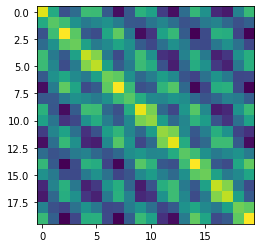

In [2355]:
plt.imshow(m.kern.K(t1,t1))

In [ ]:
%matplotlib inline

noise = 1e-4
shift = +0
t1 = np.linspace(0,5, 20).reshape(-1,1) + shift
# create simple GP Model
# kernel_lfm1 = LFM2(input_dim=1,
#                  lengthscales=np.array([1]), bvec=np.array([10]), Cvec=np.array([0.3]),
#                  Smat=np.array([[1.0]]))

kernel_lfm1 = LFM2(input_dim=1,
                 lengthscales=np.array([1]), bvec=np.array([10]), Cvec=np.array([0.001]),
                 Smat=np.array([[1.0]]), debug=True)


y1 = np.sin(5*t1)



# m = GPy.core.gp.GP(t1*3, np.exp(-t1*3), kernel=kernel_lfm1, likelihood=likelihood)
print("why")
m0 = GPy.models.GPRegression(t1, y1 , kernel=kernel_lfm1, noise_var=noise)
print("regression")

m0.kern.lengthscales.constrain_positive() 
m0.kern.Cvec.constrain_positive() 
m0.kern.Smat.constrain_positive() 
m0.likelihood.variance.fix()

m0.plot(plot_limits=(0 + shift, 8 + shift))
plt.show()
# # set the lengthscale to be something sensible (defaults to 1)
# m.kern.lengthscale = 10.

optimize = True
plot = True
if optimize:
    m0.optimize('scg', max_iters=100, messages=True)
if plot:
    print(m.normalizer)
#     m.normalizer = False
    plt.show()
    plt.figure()
    tdem =  np.linspace(0  , 10  , 300).reshape(-1,1) + shift
    
    m0.plot(plot_limits=(0 + shift, 20 + shift))
#     plt.plot(tdem,  np.sin(5*tdem))
    
    
    tcomp = np.linspace(0,3, 100).reshape(-1,1) + shift
    
    plt.show()
    tstar =  np.linspace(0 ,5.2 , 300).reshape(-1,1) + shift

    k_train =  m.kern.K(t1,t1)
    I = m0.likelihood.variance * np.eye(k_train.shape[0])
    k_test = m0.kern.K(tstar,t1)

    W = k_test.dot(np.linalg.inv(k_train + I ))

    mu = W.dot(y1)
    plt.show()
    plt.plot(tstar, m0.predict(tstar, full_cov=True)[0])
    plt.plot(tstar, mu)
    plt.plot(t1, y1, 'o')
#     (X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values)
#     dbe =  (vec_k_q_test(X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values)  -  vec_k_q_test(X, X2, self.lengthscales.values, self.bvec.values, np.array([1]), self.Cvec.values, self.Smat.values) ) / 0.0001

why


In [2017]:
np.linalg.eigh(k_train)[0].min()

8.193205293150909e-08

In [1755]:
np.linalg.matrix_rank(k_train + I)

20

In [1610]:
ks = 0.5 * (k_train + k_train.T)
keksimus = k_train + I
np.linalg.eigh(keksimus)[0]

array([-3.35853286e-03,  1.00000000e-02,  1.00000000e-02,  1.00000000e-02,
        1.00000000e-02,  1.00000001e-02,  1.00000014e-02,  1.00000121e-02,
        1.00000882e-02,  1.00005750e-02,  1.00034202e-02,  1.00189763e-02,
        1.01007531e-02,  1.05296697e-02,  1.29066865e-02,  2.75491488e-02,
        1.20803197e-01,  7.24208061e-01,  3.88058571e+00,  7.58487057e+00])

In [1609]:
np.diag(keksimus)

array([0.01      , 0.02527453, 0.1079558 , 0.2643695 , 0.45753652,
       0.63985712, 0.7769504 , 0.85597843, 0.88218047, 0.87072174,
       0.83907265, 0.80205138, 0.76962297, 0.74672838, 0.73428416,
       0.7306329 , 0.73294482, 0.73829305, 0.74430939, 0.74945413])

In [1585]:
k_train.shape

(20, 20)

In [1586]:
np.linalg.eigh(0.5*(k_train + k_train.T) )[0]

array([-1.33585329e-02, -3.09593497e-16,  1.89859775e-14,  6.28147609e-13,
        1.12256128e-11,  1.42497599e-10,  1.43191897e-09,  1.20556417e-08,
        8.81652205e-08,  5.74994719e-07,  3.42022211e-06,  1.89762869e-05,
        1.00753113e-04,  5.29669665e-04,  2.90668651e-03,  1.75491488e-02,
        1.10803197e-01,  7.14208061e-01,  3.87058571e+00,  7.57487057e+00])

In [1587]:
np.abs(k_train - k_train.T).max()

2.220446049250313e-16

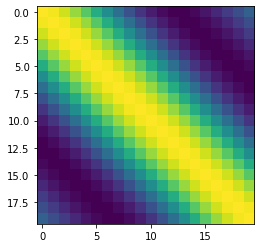

In [1629]:
plt.imshow(k_train)

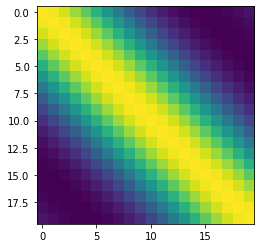

In [1589]:
plt.imshow(m.kern.K(t1 +50,t1+50))

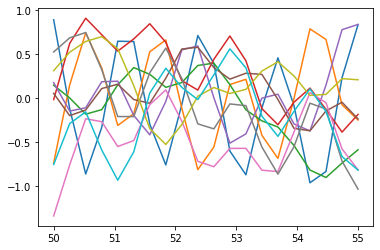

In [2354]:
ktrain= m.kern.K(t1 ,t1)
guys = np.random.multivariate_normal(np.zeros(ktrain.shape[0]), ktrain, 10)
guys.shape
[plt.plot(t1, guy) for guy in guys];

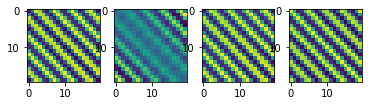

In [2357]:
from copy import deepcopy
m_safe = deepcopy(m)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1e0b1ead9c8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e0ae93e188>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e0b37c2f48>]}

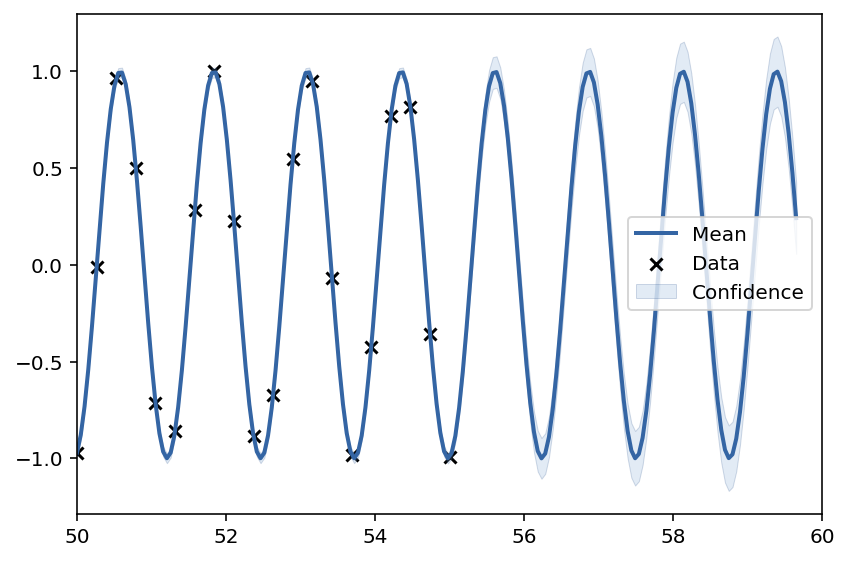

In [2367]:
%matplotlib qt
%matplotlib qt
m_safe.plot(plot_limits=(0 + shift, 10 + shift))